In [1]:
%load_ext autoreload
%autoreload 2
import numpy as np
import torch 
import os
import glob
from matplotlib import pyplot as plt
import os
import torch
# Cd to code
import os
import sys
os.chdir('/cluster/home/kheuto01/code/prob_diff_topk')
sys.path.append('/cluster/home/kheuto01/code/prob_diff_topk')

from datasets import example_datasets, to_numpy
from torch_models import  MixtureOfTruncNormModel, torch_bpr_uncurried, deterministic_bpr
from torch_perturb.torch_pert_topk import PerturbedTopK
from distributions import QuantizedNormal



2024-08-29 16:32:34.261292: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-08-29 16:32:34.298012: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-29 16:32:34.298037: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-29 16:32:34.298946: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-08-29 16:32:34.304793: I tensorflow/core/platform/cpu_feature_guar

In [64]:
seed=360
# tracts/distributions
S=7

# total timepoints
T= 500
K=5

dist_S = [QuantizedNormal(10, 0.3),
          QuantizedNormal(20, 0.3),
          QuantizedNormal(30, 0.3),
          QuantizedNormal(40, 0.3),
          QuantizedNormal(50, 0.3),
          QuantizedNormal(60, 0.3),
          QuantizedNormal(100, 0.3)]

train_y_TS = np.zeros((T, S))
for s, dist in enumerate(dist_S):
    random_state = np.random.RandomState(10000 * seed + s*123456)
    train_y_TS[:, s] = dist.rvs(size=T, random_state=random_state)

(array([0.04813665, 0.        , 0.        , 0.04534472, 0.00279193,
        0.        , 0.00163665, 0.0465    , 0.        , 0.        ,
        0.04813665, 0.        , 0.        , 0.04572981, 0.00240683,
        0.        , 0.00192547, 0.04621118, 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.04813665]),
 array([  9.        ,  11.96774194,  14.93548387,  17.90322581,
         20.87096774,  23.83870968,  26.80645161,  29.77419355,
         32.74193548,  35.70967742,  38.67741935,  41.64516129,
         44.61290323,  47.58064516,  50.5483871 ,  53.51612903,
         56.48387097,  59.4516129 ,  62.41935484,  65.38709677,
         68.35483871,  71.32258065,  74.29032258,  77.25806452,
         80.22580645,  83.19354839,  86.16129032,  89.12903226,
         92.09677419,  95.06451613,  98.03225806, 101.        ]),
 <BarContainer object of 31 artists>)

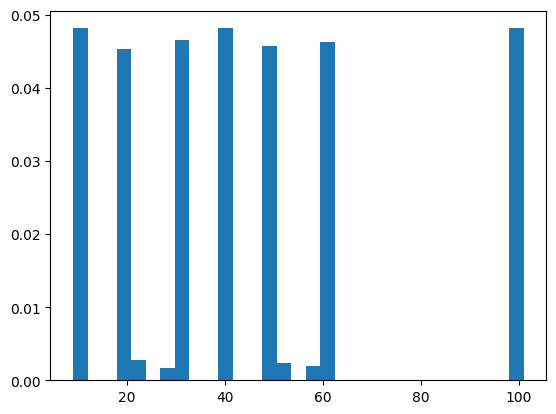

In [65]:
plt.hist(train_y_TS[:, :].flatten(), bins=31, density=True)

In [66]:
optimizer = torch.optim.Adam(model.parameters())
M_score_func, M_action = 100, 100
perturbed_top_K_func = PerturbedTopK(k=K)
bpr_weight, nll_weight = 1,1
from torch_training import train_epoch
threshold=0.5

In [21]:
model = MixtureOfTruncNormModel(num_components=2, S=S)

In [94]:
means = [20,70]
scales = [5, 5]
softinv_means = torch.tensor(means) + torch.log(-torch.expm1(-torch.tensor(means)))
softinv_scales = torch.tensor(scales) - 0.2 + torch.log1p(-torch.expm1(-torch.tensor(scales)+0.2))
mix_weights = torch.log(1e-13 + torch.tensor(np.array([[1,0], [1,0], [1,0], [1,0], [1,0], [0,1], [0,1]])).view(-1))
model.update_params(torch.cat([softinv_means, softinv_scales, mix_weights.view(-1)]))

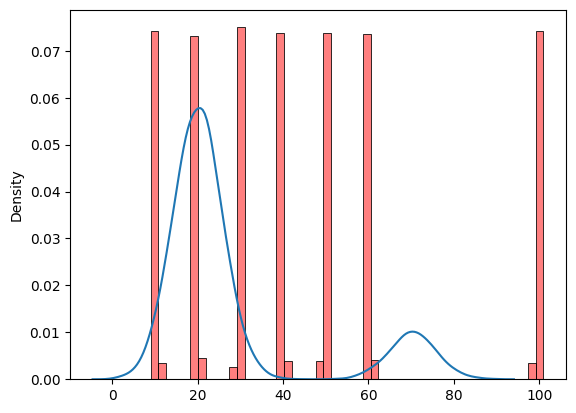

In [92]:
model.plot_learned(data=train_y_TS)

In [95]:
train_epoch(model, optimizer, K, threshold, T, M_score_func, M_action, train_y_TS, perturbed_top_K_func, bpr_weight, nll_weight, update=False)

det bpr: 0.8884769550813212
Pert bpr: 0.8928710087755474
nll: 8.170468453897604
Loss: 8.170468453897604


(tensor(8.1705, dtype=torch.float64),
 tensor(0.8885, dtype=torch.float64),
 tensor(8.1705, dtype=torch.float64),
 MixtureOfTruncNormModel())

In [75]:
train_epoch(model, optimizer, K, threshold, T, M_score_func, M_action, train_y_TS, perturbed_top_K_func, bpr_weight, nll_weight, update=False)

det bpr: 0.853615304750196
Pert bpr: 0.8571493479194888
nll: 3.847520192798354
Loss: 3.847520192798354


(tensor(3.8475, dtype=torch.float64),
 tensor(0.8536, dtype=torch.float64),
 tensor(3.8475, dtype=torch.float64),
 MixtureOfTruncNormModel())

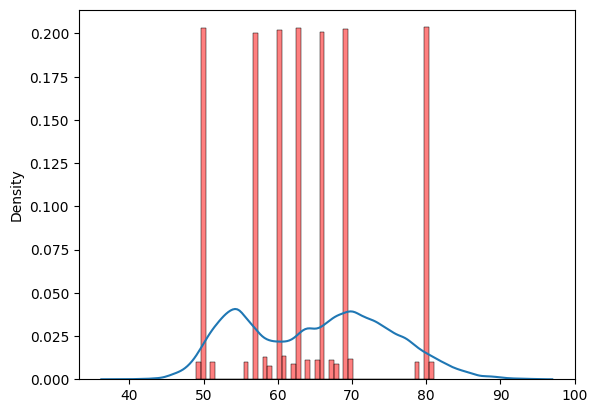

det bpr: 1.0
Pert bpr: 0.9559373863580805
nll: 3.1896442349595175
Loss: 3.1896442349595175


(tensor(3.1896, dtype=torch.float64),
 tensor(1., dtype=torch.float64),
 tensor(3.1896, dtype=torch.float64),
 MixtureOfTruncNormModel())